In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [78]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc

In [15]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [16]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)


In [17]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [18]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [19]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [21]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

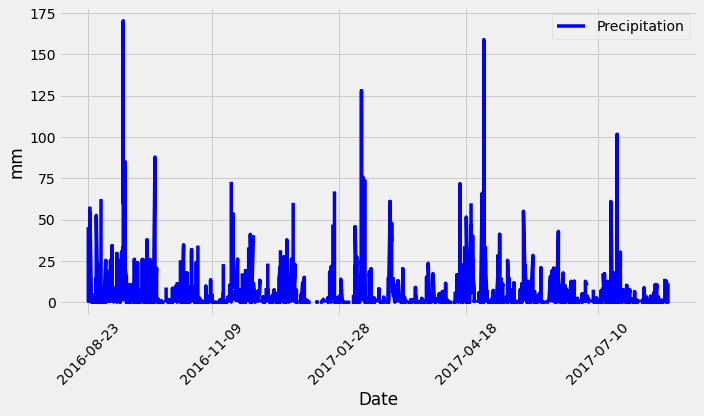

In [84]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
end_date = pd.to_datetime(most_recent_date).date() # Convert string to date format
start_date = end_date - pd.Timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).\
            filter(Measurement.date >= start_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names

df = pd.DataFrame(results, columns=["Date", "Precipitation"])
# Sort the dataframe by date
df = df.sort_values("Date")

# Use Pandas Plotting with Matplotlib to plot the data

# List of dates to display on x-axis
dates_to_display = ['2016-08-23', '2016-11-09', '2017-01-28', '2017-04-18', '2017-07-10']

plt.figure(figsize=(10,6))
plt.plot(df["Date"], df["Precipitation"], label="Precipitation", color='blue', linewidth=3.5)
plt.xlabel("Date")
plt.ylabel("mm")  # Modified y-axis label
plt.xticks(dates_to_display, rotation=45)  # Set specific dates on the x-axis
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()




In [54]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2021.000000
mean,4.505888
std,11.713487
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


# Exploratory Station Analysis

In [66]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(Station).count()
total_stations


9

In [64]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station,func.count(Measurement.station)).\
                               group_by(Measurement.station).\
                               order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [67]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
result = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
                filter(Measurement.station == 'USC00519281').order_by(func.min(Measurement.tobs)).all()
result

[(12.2, 29.4, 22.03582251082252)]

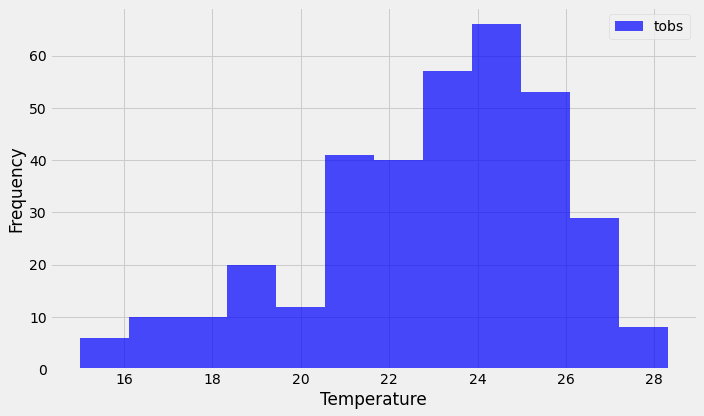

In [83]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Calculate start date which is 12 months from the end_date
start_date = end_date - dt.timedelta(days=365) 

# Determine the station with the most observations
most_active_station = (session.query(Measurement.station)
                                .group_by(Measurement.station)
                                .order_by(desc(func.count(Measurement.station)))
                                .first())[0]

# Query the last 12 months of TOBS data for the most active station
tobs_data = (session.query(Measurement.date, Measurement.tobs)
                    .filter(Measurement.station == most_active_station)
                    .filter(Measurement.date >= start_date)
                    .all())

# Convert query results to DataFrame
tobs_df = pd.DataFrame(tobs_data, columns=['Date', 'Temperature'])

# Plot the results as a histogram with bins=12
plt.figure(figsize=(10,6))
plt.hist(tobs_df['Temperature'], bins=12, color='blue', alpha=0.7)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(['tobs'])
plt.tight_layout()
plt.show()




# Close Session

In [82]:
# Close Session
session.close()